In [1]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
import shutil
import cv2

In [2]:
# images are very large to reduce process time first resize all the images in the dataset 
# and store the resized dataset in the kaggle working directory/resized. Resizing first is
# faster than doing the resizing as part of the training loop where each image is resized for every epoch
sdir=r'/home/student/Desktop/Code/re_daaset/resized'
# working_dir=r'/home/student/Desktop/Code/re_daaset'
height=224 # set desired resized image height
width=224  # set desired resized image width
# dest_dir=os.path.join(working_dir, 'resized') # directory holding resized dataset
slist=os.listdir(sdir)
classes=[]
for klass in slist:
    classpath=os.path.join(sdir,klass)
    if os.path.isdir(classpath): # make sure it is a directory not a file
        classes.append(klass)
        

In [3]:
# Input the resized dataset make a list or filepaths and labels for each image file
working_dir=r'/home/student/Desktop/Code/re_daaset'
dest_dir=os.path.join(working_dir, 'resized')
limiter=150 # set a value for the maximum number of image files to use for any class
class_count=len(classes)# number of classes
fcount_list=[]
filepaths=[]# create empty list to hold path to image files
labels=[] # create empty list of labels associated with each file
for klass in classes: # iterate through the classes
    classpath=os.path.join(dest_dir,klass)
    if os.path.isdir(classpath):
        flist=sorted(os.listdir(classpath))# get list of files in each class    
        fcount=len(flist)
        if fcount > limiter: #if there are more files than the limiter value select limiter number of files
            flist=np.random.choice(flist, limiter, replace=False)
        fcount_list.append(len(flist)) # make a list of the number of files in each class    
        desc=f'{klass:30s}'
        for f in tqdm(flist, ncols=100, colour='blue', desc=desc, unit='files'): # iterate through the files in each class
            fpath=os.path.join(classpath,f)
            filepaths.append(fpath)
            labels.append(klass)
zip_list=zip(fcount_list,classes)
ordered_list=sorted(zip_list) # order the list by the number of files
fc='File Count'
k='Class'
print(f'the dataset has {class_count} classes listed below:')
print(f'{fc:^12s}{k:^45s}')
for d in ordered_list:
    print(f'{str(d[0]):^12s}{d[1]:^45s}')
          

tomato__N_K                   : 100%|████████████████████████| 40/40 [00:00<00:00, 471270.11files/s]

the dataset has 57 classes listed below:
 File Count                     Class                    
     24                   bottle_gourd__JAS              
     25                 ridge_gourd__PLEI_MIT            
     28                   bottle_gourd__DM               
     28                   bottle_gourd__LS               
     29                 bottle_gourd__JAS_MIT            
     30                    bottle_gourd__K               
     31                 bottle_gourd__healthy            
     32                    tomato__JAS_MIT               
     33                    ridge_gourd__PC               
     33                    snake_gourd__LS               
     34                  bottle_gourd__N_Mg              
     34                   cucumber__healthy              
     34                     eggplant__JAS                
     34                   ridge_gourd__N_Mg              
     35                   bitter_gourd__JAS              
     35                   bitte

In [4]:
# make a dataframe with columns filepaths, labels
Fseries=pd.Series(filepaths, name='filepaths')
Lseries=pd.Series(labels, name='labels')
df=pd.concat([Fseries, Lseries], axis=1)
print (df.head())
print(f'the dataframe length is {len(df)}')

                                           filepaths           labels
0  /home/student/Desktop/Code/re_daaset/resized/t...  tomato__JAS_MIT
1  /home/student/Desktop/Code/re_daaset/resized/t...  tomato__JAS_MIT
2  /home/student/Desktop/Code/re_daaset/resized/t...  tomato__JAS_MIT
3  /home/student/Desktop/Code/re_daaset/resized/t...  tomato__JAS_MIT
4  /home/student/Desktop/Code/re_daaset/resized/t...  tomato__JAS_MIT
the dataframe length is 4088


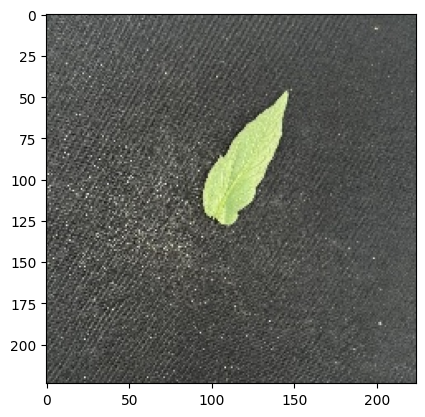

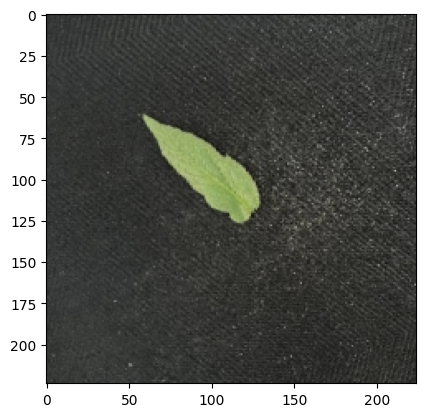

In [5]:
import albumentations as A # import albumentations
import matplotlib
import matplotlib.pyplot as plt # import matplot to show images
def get_augmented_image(image): # given an image this function returns an augmented image
    width=int(image.shape[1]*.8)
    height=int(image.shape[0]*.8)
    transform= A.Compose([
        A.HorizontalFlip(p=.5),
        A.Rotate(limit=30, p=.25),
        A.RandomBrightnessContrast(p=.5),
        A.RandomGamma(p=.5),
        A.RandomCrop(width=width, height=height, p=.25) ])    
    return transform(image=image)['image']
# lets test this to see if it works correctly
fpath=df['filepaths'][0]
img=plt.imread(fpath)
aug_img=get_augmented_image(img)
plt.imshow(img)
plt.show() # show the original image
plt.imshow(aug_img)
plt.show()# show the augmented image


In [6]:
augpath=os.path.join(working_dir, 'aug')
if os.path.isdir(augpath):
    shutil.rmtree(augpath)# if directory already exists remove it, we want to start with a clean empty directory
os.mkdir(augpath)
# Iterate through the classes, for a class with less than limiter number of images create augmented images


filepaths=[]
labels=[]
for count, klass in ordered_list:
    if count < limiter: # if this class has less than the limiter value of files
        delta=limiter - count # this is how many augmented images we need to create for this class
        print (f'creating {delta} augmented images for class {klass}')
        classpath=os.path.join(dest_dir,klass)# path to class in resized dataset
        dest_classpath=os.path.join(augpath,klass) # where to store files for this class
        os.mkdir(dest_classpath)# create directory to hold the augmented images for this class
        flist=sorted(os.listdir(classpath))# get list of files for this class
        for i in range(delta): # iterate to create delta number of augmented images
            j=i % count # delta may be greaor than the number of files in the class so use mod of count as file indexer
            fpath=os.path.join(classpath, flist[j]) # path to the image file to augment
            dest_fpath=os.path.join(dest_classpath,str(i)+'.jpg')# path of where to store the augmented image
            img=cv2.imread(fpath)  # read in the image          
            aug_img=get_augmented_image(img) # augment the image
            cv2.imwrite(dest_fpath, aug_img)# save the augmented image
            filepaths.append(dest_fpath) # list of augmented image file paths
            labels.append(klass)# list of augmented image associated class label


creating 126 augmented images for class bottle_gourd__JAS
creating 125 augmented images for class ridge_gourd__PLEI_MIT
creating 122 augmented images for class bottle_gourd__DM
creating 122 augmented images for class bottle_gourd__LS
creating 121 augmented images for class bottle_gourd__JAS_MIT
creating 120 augmented images for class bottle_gourd__K
creating 119 augmented images for class bottle_gourd__healthy
creating 118 augmented images for class tomato__JAS_MIT
creating 117 augmented images for class ridge_gourd__PC
creating 117 augmented images for class snake_gourd__LS
creating 116 augmented images for class bottle_gourd__N_Mg
creating 116 augmented images for class cucumber__healthy
creating 116 augmented images for class eggplant__JAS
creating 116 augmented images for class ridge_gourd__N_Mg
creating 115 augmented images for class bitter_gourd__JAS
creating 115 augmented images for class bitter_gourd__LS
creating 114 augmented images for class eggplant__FB
creating 114 augmente

In [7]:
filepaths

['/home/student/Desktop/Code/re_daaset/aug/bottle_gourd__JAS/0.jpg',
 '/home/student/Desktop/Code/re_daaset/aug/bottle_gourd__JAS/1.jpg',
 '/home/student/Desktop/Code/re_daaset/aug/bottle_gourd__JAS/2.jpg',
 '/home/student/Desktop/Code/re_daaset/aug/bottle_gourd__JAS/3.jpg',
 '/home/student/Desktop/Code/re_daaset/aug/bottle_gourd__JAS/4.jpg',
 '/home/student/Desktop/Code/re_daaset/aug/bottle_gourd__JAS/5.jpg',
 '/home/student/Desktop/Code/re_daaset/aug/bottle_gourd__JAS/6.jpg',
 '/home/student/Desktop/Code/re_daaset/aug/bottle_gourd__JAS/7.jpg',
 '/home/student/Desktop/Code/re_daaset/aug/bottle_gourd__JAS/8.jpg',
 '/home/student/Desktop/Code/re_daaset/aug/bottle_gourd__JAS/9.jpg',
 '/home/student/Desktop/Code/re_daaset/aug/bottle_gourd__JAS/10.jpg',
 '/home/student/Desktop/Code/re_daaset/aug/bottle_gourd__JAS/11.jpg',
 '/home/student/Desktop/Code/re_daaset/aug/bottle_gourd__JAS/12.jpg',
 '/home/student/Desktop/Code/re_daaset/aug/bottle_gourd__JAS/13.jpg',
 '/home/student/Desktop/Code/r

In [8]:
labels

['bottle_gourd__JAS',
 'bottle_gourd__JAS',
 'bottle_gourd__JAS',
 'bottle_gourd__JAS',
 'bottle_gourd__JAS',
 'bottle_gourd__JAS',
 'bottle_gourd__JAS',
 'bottle_gourd__JAS',
 'bottle_gourd__JAS',
 'bottle_gourd__JAS',
 'bottle_gourd__JAS',
 'bottle_gourd__JAS',
 'bottle_gourd__JAS',
 'bottle_gourd__JAS',
 'bottle_gourd__JAS',
 'bottle_gourd__JAS',
 'bottle_gourd__JAS',
 'bottle_gourd__JAS',
 'bottle_gourd__JAS',
 'bottle_gourd__JAS',
 'bottle_gourd__JAS',
 'bottle_gourd__JAS',
 'bottle_gourd__JAS',
 'bottle_gourd__JAS',
 'bottle_gourd__JAS',
 'bottle_gourd__JAS',
 'bottle_gourd__JAS',
 'bottle_gourd__JAS',
 'bottle_gourd__JAS',
 'bottle_gourd__JAS',
 'bottle_gourd__JAS',
 'bottle_gourd__JAS',
 'bottle_gourd__JAS',
 'bottle_gourd__JAS',
 'bottle_gourd__JAS',
 'bottle_gourd__JAS',
 'bottle_gourd__JAS',
 'bottle_gourd__JAS',
 'bottle_gourd__JAS',
 'bottle_gourd__JAS',
 'bottle_gourd__JAS',
 'bottle_gourd__JAS',
 'bottle_gourd__JAS',
 'bottle_gourd__JAS',
 'bottle_gourd__JAS',
 'bottle_g

In [9]:
# now we can create the dataframe for augmented images
Fseries=pd.Series(filepaths, name='filepaths')
Lseries=pd.Series(labels, name='labels')
aug_df=pd.concat([Fseries, Lseries], axis=1)

In [10]:
print(len(df), len(aug_df))
df=pd.concat([df, aug_df], axis=0)
print (len(df))
print (df.head())
print (df.tail())
# lets make sure each class has limiter number of images 
vc=df['labels'].value_counts()
vu=len(df['labels'].unique())
print (vc)
print (vu)

4088 4462
8550
                                           filepaths           labels
0  /home/student/Desktop/Code/re_daaset/resized/t...  tomato__JAS_MIT
1  /home/student/Desktop/Code/re_daaset/resized/t...  tomato__JAS_MIT
2  /home/student/Desktop/Code/re_daaset/resized/t...  tomato__JAS_MIT
3  /home/student/Desktop/Code/re_daaset/resized/t...  tomato__JAS_MIT
4  /home/student/Desktop/Code/re_daaset/resized/t...  tomato__JAS_MIT
                                              filepaths             labels
4457  /home/student/Desktop/Code/re_daaset/aug/bitte...  bitter_gourd__N_K
4458  /home/student/Desktop/Code/re_daaset/aug/bitte...  bitter_gourd__N_K
4459  /home/student/Desktop/Code/re_daaset/aug/bitte...    bitter_gourd__N
4460  /home/student/Desktop/Code/re_daaset/aug/bitte...    bitter_gourd__N
4461  /home/student/Desktop/Code/re_daaset/aug/bitte...    bitter_gourd__N
labels
tomato__JAS_MIT          150
bitter_gourd__N_Mg       150
ridge_gourd__PLEI_MIT    150
eggplant__N          

In [11]:
# now df contains the full dataset and each class has limiter number of images for a balanced dataset
# lets partition the dataset into a train set, a test set and a validation set
from sklearn.model_selection import train_test_split
train_df, dummy_df=train_test_split(df, train_size=.8, shuffle=True, random_state=123, stratify=df['labels'])
valid_df, test_df=train_test_split(dummy_df, train_size=.5, shuffle=True, random_state=123, stratify=dummy_df['labels'])
print(f'train_df length= {len(train_df)} test_df length= {len(test_df)} valid_df length= {len(valid_df)}')

train_df length= 6840 test_df length= 855 valid_df length= 855


In [12]:
# now create generators for the dataframes
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
img_size=(224,224)
bs=40
gen=ImageDataGenerator()
train_gen=gen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels', target_size=img_size,seed=123,
                                       class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=bs)
valid_gen=gen.flow_from_dataframe(valid_df, x_col='filepaths', y_col='labels', target_size=img_size,seed=123,
                                       class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=bs)
test_gen=gen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels', target_size=img_size,seed=123,
                                       class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=bs)

2024-01-14 19:39:22.577618: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-14 19:39:22.612000: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-14 19:39:22.614777: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-14 19:39:23.228821: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Found 6840 validated image filenames belonging to 57 classes.
Found 855 validated image filenames belonging to 57 classes.
Found 855 validated image filenames belonging to 57 classes.


In [13]:
def F1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [14]:
from keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization
from keras.optimizers import Adam, Adamax
from keras.metrics import categorical_crossentropy
from keras import regularizers
from keras.models import Model
from keras import backend as K
from keras.layers import Dense, Activation, Flatten
from keras.models import Sequential
model = Sequential()
inputShape = (224,224,3)
chanDim = -1

model.add(Conv2D(32, (3, 3), padding="same",input_shape=inputShape))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(1024))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(57))
model.add(Activation("softmax"))
lr=.001
epochs=50
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.003,
    decay_steps=10000,
    decay_rate=0.9)
opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
# distribution
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy",F1_score])

In [15]:
# we are now ready to train the model but first lets define some useful callbacks
#rlronp controls learning rate based on validation loss
#estop stops training if value loss fails to reduce after 4 consecutive epochs
rlronp=tf.keras.callbacks.ReduceLROnPlateau( monitor="val_loss", factor=0.4,  patience=2, verbose=1)
estop=tf.keras.callbacks.EarlyStopping(monitor="val_loss",  patience=4, verbose=1, restore_best_weights=True)
callbacks=[rlronp, estop]

# Note: ignore warning training will proceed properly
history=model.fit(x=train_gen,   epochs=epochs, verbose=1, callbacks=callbacks,  validation_data=valid_gen,
                   validation_steps=None,  shuffle=True,  initial_epoch=0) # train the model


Epoch 1/50


2024-01-14 19:39:24.182180: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


171/171 [==============================] - ETA: 0s - loss: 0.1987 - accuracy: 0.0982 - F1_score: 0.0330

2024-01-14 19:43:52.822328: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


171/171 [==============================] - 274s 2s/step - loss: 0.1987 - accuracy: 0.0982 - F1_score: 0.0330 - val_loss: 0.1842 - val_accuracy: 0.0409 - val_F1_score: 0.0329 - lr: 0.0030
Epoch 2/50
171/171 [==============================] - 273s 2s/step - loss: 0.0857 - accuracy: 0.2095 - F1_score: 0.1123 - val_loss: 0.1601 - val_accuracy: 0.0480 - val_F1_score: 0.0402 - lr: 0.0030
Epoch 3/50
171/171 [==============================] - 269s 2s/step - loss: 0.0739 - accuracy: 0.2822 - F1_score: 0.1939 - val_loss: 0.0817 - val_accuracy: 0.1895 - val_F1_score: 0.1212 - lr: 0.0030
Epoch 4/50
171/171 [==============================] - 262s 2s/step - loss: 0.0679 - accuracy: 0.3197 - F1_score: 0.2471 - val_loss: 0.1642 - val_accuracy: 0.0842 - val_F1_score: 0.0658 - lr: 0.0030
Epoch 5/50
171/171 [==============================] - 259s 2s/step - loss: 0.0628 - accuracy: 0.3553 - F1_score: 0.2971 - val_loss: 0.0730 - val_accuracy: 0.3251 - val_F1_score: 0.2466 - lr: 0.0030
Epoch 6/50
171/171 [=

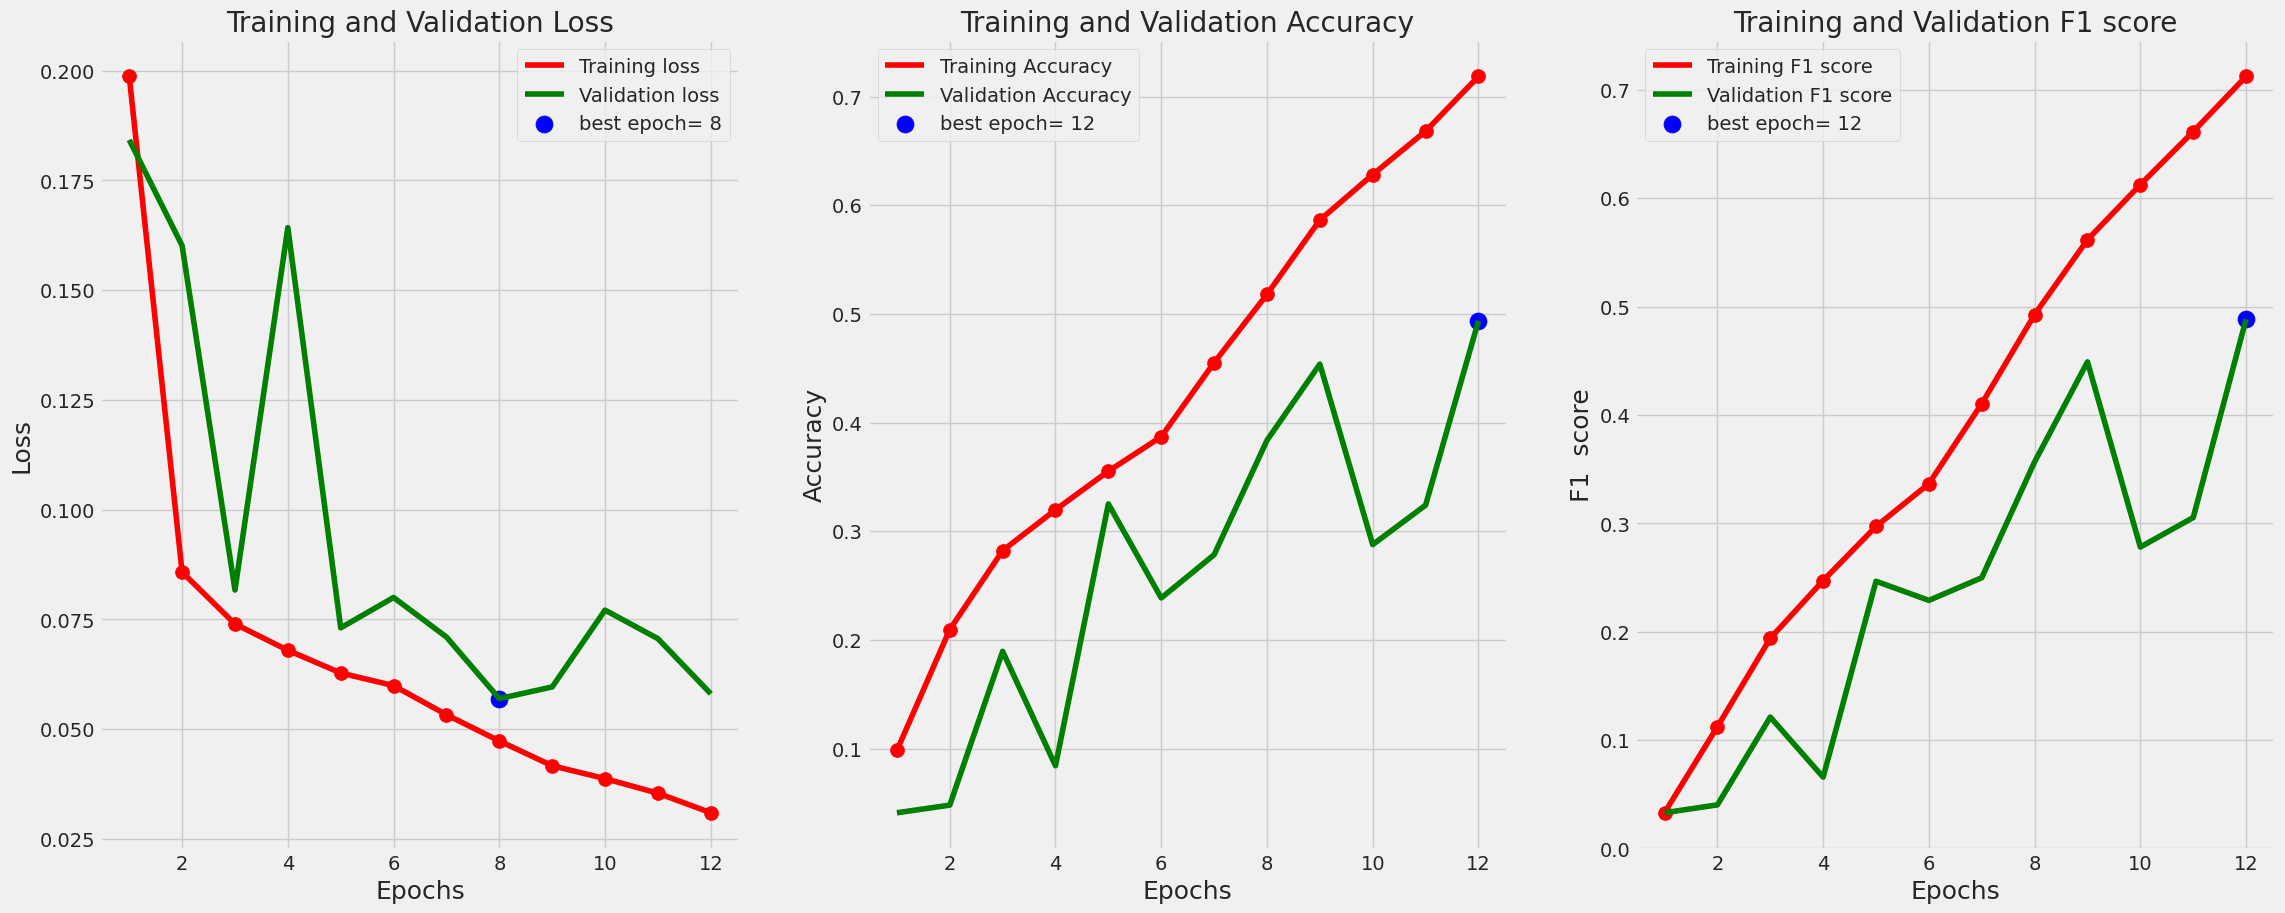

In [16]:
# lets define a function to plot the training data
import seaborn as sns
from matplotlib import pyplot as plt
sns.set_style('darkgrid')
def tr_plot(tr_data):
    start_epoch=0
    #Plot the training and validation data
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    tf1=tr_data.history['F1_score']
    vf1=tr_data.history['val_F1_score']    
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)   
    index_loss=np.argmin(vloss)#  this is the epoch with the lowest validation loss
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    indexf1=np.argmax(vf1)
    vf1_highest=vf1[indexf1]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch) 
    f1_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=3, figsize=(25,10))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].scatter(Epochs, tloss, s=100, c='red')    
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs', fontsize=18)
    axes[0].set_ylabel('Loss', fontsize=18)
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].scatter(Epochs, tacc, s=100, c='red')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs', fontsize=18)
    axes[1].set_ylabel('Accuracy', fontsize=18)
    axes[1].legend()
    axes[2].plot (Epochs,tf1,'r',label= 'Training F1 score')    
    axes[2].plot (Epochs,vf1,'g',label= 'Validation F1 score')
    index_tf1=np.argmax(tf1)#  this is the epoch with the highest training F1 score
    tf1max=tf1[index_tf1]
    index_vf1=np.argmax(vf1)# thisiis the epoch with the highest validation F1 score
    vf1max=vf1[index_vf1]
    axes[2].scatter(index_vf1+1 +start_epoch,vf1max, s=150, c= 'blue', label=vc_label)    
    axes[2].scatter(Epochs, tf1, s=100, c='red')
    axes[2].set_title('Training and Validation F1 score')
    axes[2].set_xlabel('Epochs', fontsize=18)
    axes[2].set_ylabel('F1  score', fontsize=18)
    axes[2].legend()    
    plt.tight_layout    
    plt.show()
    return 

tr_plot(history) # plot the training data

2024-01-14 20:28:04.600691: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


22/22 [==============================] - 4s 198ms/step
There were 520 errors in 855 tests for an accuracy of  39.18 and an F1 score of  38.26


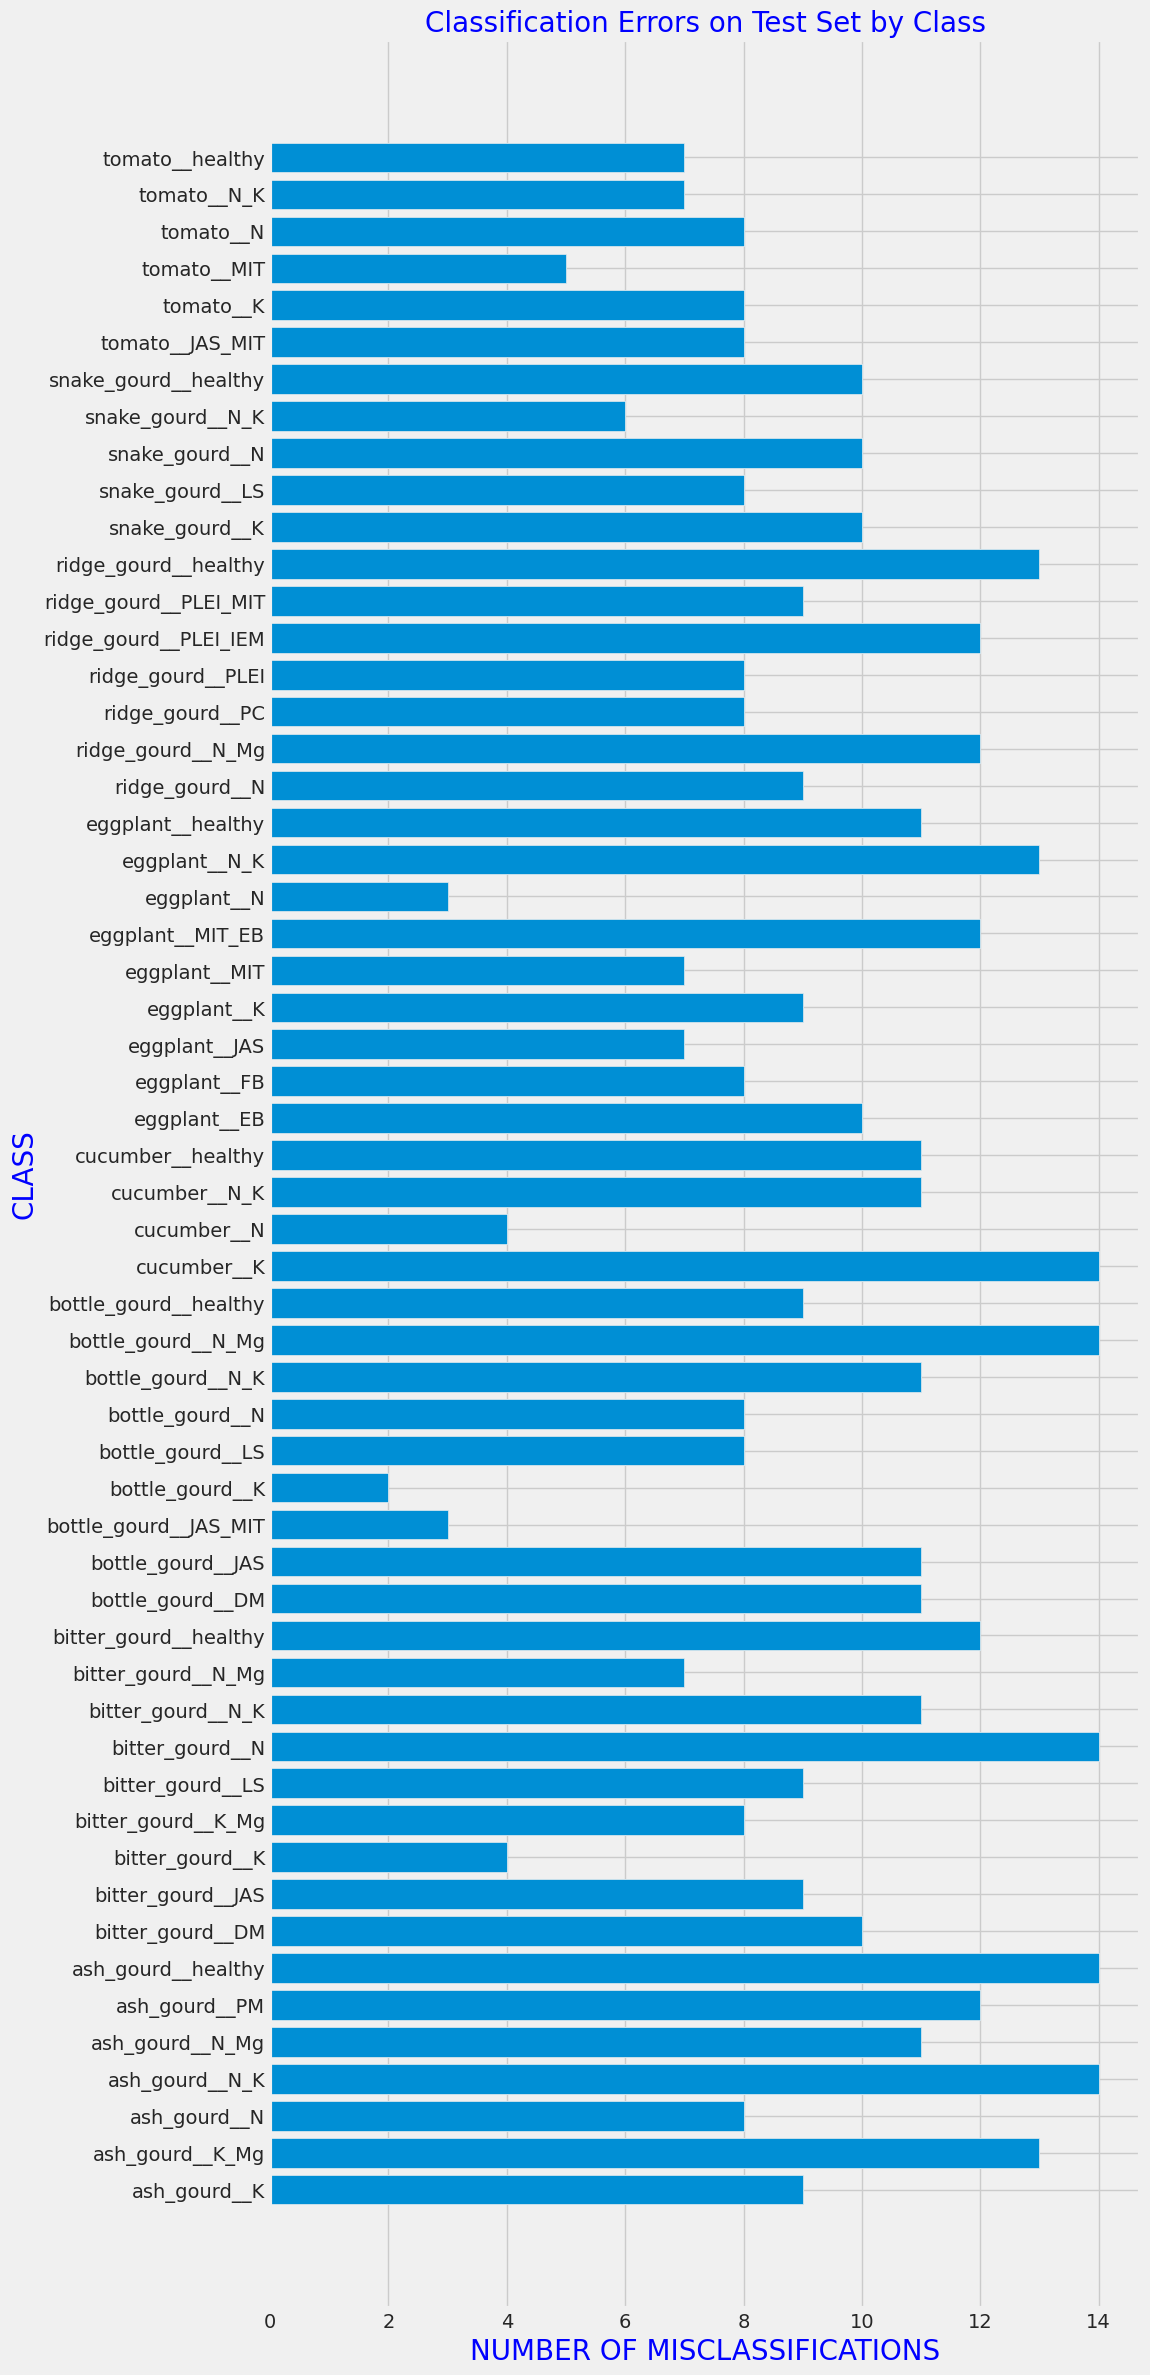

Classification Report:
----------------------
                        precision    recall  f1-score   support

         ash_gourd__K     0.2500    0.4000    0.3077        15
      ash_gourd__K_Mg     0.3333    0.1333    0.1905        15
         ash_gourd__N     0.3500    0.4667    0.4000        15
       ash_gourd__N_K     0.5000    0.0667    0.1176        15
      ash_gourd__N_Mg     0.2667    0.2667    0.2667        15
        ash_gourd__PM     0.3750    0.2000    0.2609        15
   ash_gourd__healthy     0.1111    0.0667    0.0833        15
     bitter_gourd__DM     0.4545    0.3333    0.3846        15
    bitter_gourd__JAS     0.2609    0.4000    0.3158        15
      bitter_gourd__K     0.7333    0.7333    0.7333        15
   bitter_gourd__K_Mg     0.5833    0.4667    0.5185        15
     bitter_gourd__LS     0.4615    0.4000    0.4286        15
      bitter_gourd__N     0.3333    0.0667    0.1111        15
    bitter_gourd__N_K     0.4000    0.2667    0.3200        15
   bitt

In [17]:
# lets define a function that does predictions on the test set and computes the confusion matrix 
# and a classification report
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import f1_score
def predictor(model,test_gen):
    classes=list(test_gen.class_indices.keys())
    class_count=len(classes)
    preds=model.predict(test_gen, verbose=1)
    errors=0
    test_count =len(preds)
    misclassified_classes=[]
    misclassified_files=[]
    misclassified_as = []
    pred_indices=[]
    for i, p in enumerate (preds):
        pred_index=np.argmax(p)
        pred_indices.append(pred_index)
        true_index= test_gen.labels[i]    
        if  pred_index != true_index:        
            errors +=1        
            misclassified_classes.append(classes[true_index])
            misclassified_as.append(classes[pred_index])
            file=test_gen.filenames[i]
            split=file.split('/')
            L=len(split)           
            f=split[L-2] +' '+ split[L-1]  
            misclassified_files.append(f)

    accuracy = (test_count-errors)*100/test_count
    ytrue=np.array(test_gen.labels)
    ypred=np.array(pred_indices)
    f1score=f1_score(ytrue, ypred, average='weighted')* 100
    msg=f'There were {errors} errors in {test_count} tests for an accuracy of {accuracy:6.2f} and an F1 score of {f1score:6.2f}'
    print (msg) 
    misclassified_classes=sorted(misclassified_classes)
    if len(misclassified_classes) > 0:
        misclassifications=[]
        for klass in misclassified_classes:
            mis_count=misclassified_classes.count(klass)
            misclassifications.append(mis_count)
        unique=len(np.unique(misclassified_classes)) 
        if unique==1:
            height=int(unique)
        else:
            height =int(unique/2)
        plt.figure(figsize=(10, height))
        plt.style.use('fivethirtyeight')
        plt.barh(misclassified_classes, misclassifications )
        plt.title( 'Classification Errors on Test Set by Class', fontsize=20, color='blue')
        plt.xlabel('NUMBER OF MISCLASSIFICATIONS', fontsize=20, color='blue')
        plt.ylabel('CLASS', fontsize=20, color='blue')
        plt.show()
    if class_count <=30:
        cm = confusion_matrix(ytrue, ypred )
        # plot the confusion matrix
        plt.figure(figsize=(12, 8))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)       
        plt.xticks(np.arange(class_count)+.5, classes, rotation=90)
        plt.yticks(np.arange(class_count)+.5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()
    clr = classification_report(ytrue, ypred, target_names=classes, digits= 4) # create classification report
    print("Classification Report:\n----------------------\n", clr)
    return f1score, misclassified_files

f1score, misclassified_files= predictor(model,test_gen)# do predictions on the test set

In [18]:
# lets save the model with nomenclature subject,no of classes, image size, f1score
subject='olid'
name=f'{subject}-{str(len(classes))}-({str(img_size[0])} X {str(img_size[1])})- {f1score:5.2f}.h5'    
model_save_loc=os.path.join(working_dir, name)    
model.save(model_save_loc)        
print( f'model was saved as {model_save_loc}')


model was saved as /home/student/Desktop/Code/re_daaset/olid-57-(224 X 224)- 38.26.h5
